In [1]:
import sys
sys.path.append('..')

# Key Molecular Properties in Drug Design

Drug design is a process that needs to take into accounts multiple parameters. First, the molecule needs to be of course active, i.e. interact with its biological target to induce some therapeutic effect. Second, this molecule should also have a set of other desirable molecular properties that are known under the term ADMET (absorption, distribution, metabolism, excretion, and toxicity). These properties ensure that our compound will reach its target and will not induce any side effects.

## Activity

Biological activity of a compound is measured in a laboratory by conducting biological **assays** that tests how well our molecule binds and interacts with its biological target. An assay can be done using proteins or whole cells, and there are many types of activity measurements that can be done. For example, we can test only if the molecule binds to its target or look for a specific interaction that causes a desirable effect or inhibition. The activity values are usually expressed as:

- **EC$_{50}$**/**IC$_{50}$** - molecule concentration at which half of the effect or inhibition (blockage) is reached; the lower this value is, the stronger the effect induced by the molecule is.
- **Ki** - the inhibition constant, which measures the binding affinity; again, lower values correspond to stronger binding.
- **Inhibition in %** - the percentage of inhibited proteins.

Oftentimes, XC$_{50}$ and Ki values are converted to the negative logarithmic scale. This is denoted by the letter "*p*" in front of the activity type. This operation reduces the impact of extremely high values. After this transformation, higher values correspond to stronger activity.

For example, pIC$_{50}$ = $-\log_{10} $ IC$_{50}$.


## ADMET

There are myriads of chemical properties that can be measured to ensure the success of our molecule. Depending on the drug target, we might want to optimize different ADMET properties. If our drug needs to work in the central nervous system, we need to check the **blood-brain barrier permeability**. Other drugs that are administered orally need to **absorbed in the intestine**. Our molecule needs to be **metabolically stable**, which means it is not metabolized before it reaches its destination. On the other hand, we need to make sure it is finally metabolized and does not accumulate in the organism. Eventually, drugs can not be **toxic** or induce any serious side effects by interacting with other biological targets (**off-targets**). This is a difficult property to optimize as toxicity is a non-specific property - there are many possible interactions that can cause toxicity, e.g. **hERG inhibition** leads to severe cardiotoxicity (blocked potassium ion channels will cause heart failure).

# ChEMBL

[ChEMBL](https://www.ebi.ac.uk/chembl/) is a public database of bioactive compounds. The experimentally measured data points are gathered here and they can be used to train machine learning models. It should be noted that this database is manually curated, and the data is pulled from publications and patents. The quality of this data is not always perfect, and the same compound can have multiple drastically different activity values depending on the site the experiments were conducted in. Sometimes these values can contain errors, either caused by humans or incorrect parsing of source documents.

![assay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/96_well_plate.jpg/1599px-96_well_plate.jpg)

Activity data extracted from ChEMBL can be used to train ML models. Because we use the structural information (fingerprints or molecular graphs), these models are also called **QSAR models**, where QSAR stands for Quantitative Structure-Activity Relationship.

**Exercise 1.** Choose one of the targets below and download activity data for this target from ChEMBL. Use one of the activity types (e.g. Ki or IC$_{50}$) to train an ML model. Split the data and print the results of evaluation on the testing set.

- MAO-B (monoamine oxidase B) - its inhibitors can be used to treat symptoms of Parkinson's disease
- ACE2 (angiotensin-converting enzyme 2) - serves as an entry point for SARS-CoV-2
- COX-2 (cyclooxygenase 2) - the taget of non-steroidal anti-inflammatory drugs
- 5-HT3 (serotonin receptor 3) - common target of antiemetics (drugs against vomiting nad nausea)
- hERG - potassium ion channel that is often connected to cardiotoxicity (when inhibited)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem.AtomPairs import Pairs, Torsions
from tdc import Evaluator
import math

In [3]:
pd.set_option('display.max_columns', None)
data_path = "mao-b.csv" 
df = pd.read_csv(data_path, sep=';')
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL341071,NaN,None,196.21,0,2.00,10,Cc1cc2c(nn1)-c1ccccc1C2=O,IC50,'=',130.00,nM,6.89,NaN,NaN,UO_0000065,35.10,0.63,4.89,16.07,0,CHEMBL734178,Inhibitory concentration against Monoamine oxi...,B,BAO_0000357,single protein format,Papio hamadryas,None,None,None,None,NaN,NaN,NaN,CHEMBL2039,Monoamine oxidase B,Homo sapiens,SINGLE PROTEIN,CHEMBL1136363,1,Scientific Literature,Bioorg Med Chem Lett,2003.0,None,NaN
1,CHEMBL4111335,NaN,None,337.47,0,3.38,BDBM254597,NC1CCC(N[C@H]2C[C@@H]2c2ccc(OCc3cccnc3)cc2)CC1,IC50,'>',50000.00,nM,NaN,NaN,443212,UO_0000065,NaN,NaN,NaN,NaN,0,CHEMBL3887028,Fluorescence-Based (Inhibitor)-Screening Assay...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2039,Monoamine oxidase B,Homo sapiens,SINGLE PROTEIN,CHEMBL3886143,37,BindingDB Database,NaN,2016.0,None,NaN
2,CHEMBL4474002,NaN,None,353.80,0,1.71,25,Cc1cc(O)cc2oc(=O)c(C(=O)CCN3CCOCC3)cc12.Cl,IC50,'=',35980.00,nM,4.44,NaN,NaN,UO_0000065,14.00,0.26,2.73,5.56,0,CHEMBL4349201,Inhibition of recombinant human MAO-B expresse...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2039,Monoamine oxidase B,Homo sapiens,SINGLE PROTEIN,CHEMBL4346711,1,Scientific Literature,Eur J Med Chem,2019.0,None,NaN
3,CHEMBL4550005,NaN,None,337.80,0,2.48,27,Cc1cc(O)cc2oc(=O)c(C(=O)CCN3CCCC3)cc12.Cl,IC50,'=',43670.00,nM,4.36,NaN,NaN,UO_0000065,14.47,0.27,1.88,6.16,0,CHEMBL4349201,Inhibition of recombinant human MAO-B expresse...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL2039,Monoamine oxidase B,Homo sapiens,SINGLE PROTEIN,CHEMBL4346711,1,Scientific Literature,Eur J Med Chem,2019.0,None,NaN
4,CHEMBL4567537,NaN,None,273.70,0,4.11,19,Fc1cc(/N=C/c2ccc3[nH]ncc3c2)ccc1Cl,IC50,'=',1.91,nM,8.72,NaN,NaN,UO_0000065,31.86,0.63,4.61,21.25,0,CHEMBL4354288,Inhibition of human recombinant MAO-B expresse...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,BTI-TN-5B1-4,None,NaN,NaN,NaN,CHEMBL2039,Monoamine oxidase B,Homo sapiens,SINGLE PROTEIN,CHEMBL4351013,1,Scientific Literature,Eur J Med Chem,2019.0,CHEMBL3833782,NaN


In [4]:
activity_type = 'IC50'  
relevant_columns = ['Molecule ChEMBL ID', 'Molecule Name', 'Molecular Weight', '#RO5 Violations', 'Smiles',
                    'Standard Value', 'Standard Units', 'pChEMBL Value', 'Document Year']
df = df[(df['Standard Type'] == activity_type) & (df['Standard Relation'].str.contains('='))][relevant_columns]
df

,Molecule ChEMBL ID,Molecule Name,Molecular Weight,#RO5 Violations,Smiles,Standard Value,Standard Units,pChEMBL Value,Document Year
0,CHEMBL341071,NaN,196.21,0,Cc1cc2c(nn1)-c1ccccc1C2=O,130.00,nM,6.89,2003.0
2,CHEMBL4474002,NaN,353.80,0,Cc1cc(O)cc2oc(=O)c(C(=O)CCN3CCOCC3)cc12.Cl,35980.00,nM,4.44,2019.0
3,CHEMBL4550005,NaN,337.80,0,Cc1cc(O)cc2oc(=O)c(C(=O)CCN3CCCC3)cc12.Cl,43670.00,nM,4.36,2019.0
4,CHEMBL4567537,NaN,273.70,0,Fc1cc(/N=C/c2ccc3[nH]ncc3c2)ccc1Cl,1.91,nM,8.72,2019.0
5,CHEMBL3742068,NaN,272.27,0,O=C1CCOc2cc(OCc3ccccc3F)ccc21,58.82,nM,7.23,2015.0
...,...,...,...,...,...,...,...,...,...
5313,CHEMBL5072382,NaN,379.45,0,Cc1c(C)c2ccc(OCC3CCCN(CCCC(F)F)C3)cc2oc1=O,260.00,nM,6.58,2022.0
5314,CHEMBL5083014,NaN,395.47,0,Cc1c(C)c2ccc(OCC3CCCN(Cc4cccc(F)c4)C3)cc2oc1=O,12.00,nM,7.92,2022.0
5315,CHEMBL4866427,NaN,375.46,1,C#CCNC1CCc2c(SCCc3ccc(C(F)(F)F)cc3)cccc21,8780.00,nM,5.06,2021.0
5316,CHEMBL4877043,NaN,375.46,1,C#CCNC1CCc2c(SCCc3cccc(C(F)(F)F)c3)cccc21,3720.00,nM,5.43,2021.0


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

(3532, 883)

In [9]:
class Featurizer():
    def __init__(self, radius=2, length=2048, use_logarithm=False, **kwargs):
        self.radius = radius
        self.length = length
        self.use_logarithm = use_logarithm
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row['Standard Value']
            smiles = row['Smiles']
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            # Other fingerprints I tried; didn't seem better
            # fp = Chem.RDKFingerprint(mol)
            # fp = MACCSkeys.GenMACCSKeys(mol)
            label = y if not self.use_logarithm else -math.log10(y)
            fingerprints.append(fp)
            labels.append(label)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

featurizer = Featurizer()
X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)

In [13]:
model = RandomForestRegressor().fit(X_train, y_train)
# model = MLPRegressor(hidden_layer_sizes=(120,30), activation='relu').fit(X_train, y_train)

rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')
predictions = model.predict(X_test)
rmse_score = rmse(y_test, predictions)
mae_score = mae(y_test, predictions)
r2_score = r_squared(y_test, predictions)
print(f'RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')

RMSE, MAE, R2 = 2028993.0717632452, 187534.78187512758, -2.7518465482995267


I find those visualisations helpful (log scale was necessary due to the large variance of IC50 values)
We see the task is hard for the model.

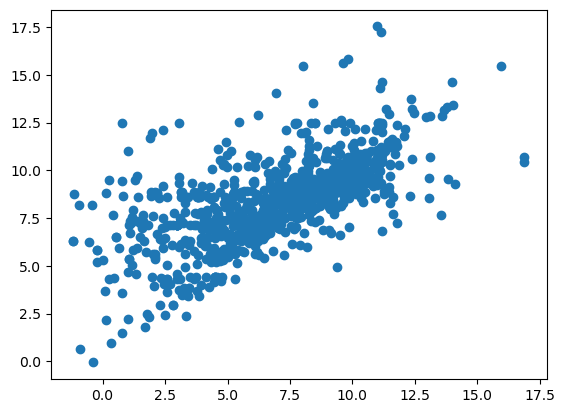

2195.6  15328.739239523802
58310.0  65729.25333333333
59.0  1348.44
68200.0  30164730.18171
20892961.31  34343.447511666665
125.89  29686.145310000004
518.0  1253.832658730159
460.0  919.3766
5780.0  7928.762699999999
1500.0  5018.4535


In [17]:
predictions = model.predict(X_test)
plt.scatter(np.log(y_test), np.log(predictions))
plt.show()
for i in range(10):
    print(f'{y_test[i]}  {predictions[i]}')

**(optional) Excercise 1.1.** *(advanced data splitting methods)*

You might be surprised how good results you can achieve using a random data split. The model performance measured this way can be misleading as ChEMBL contains many similar compounds, series of compounds containing the same scaffold, or even duplicated records. Thus, a better form of evaluation would be to employ a more advanced splitting method, e.g. **scaffold-based split** in which all compounds containing the same scaffold are put in the same set. Another option is to use a **time-based split** because most records in ChEBML should be tagged with the date of their publication. 

Don't be discouraged by the lower results you obtain with these splits. By evaluating your model this way, you get more realistic scores that better reflect the future use cases of your model. The fact that lower evaluation scores may correspond to a better model is known as the **Kubinyi paradox**.

You can now implement a more advanced data split and compare the prediction results on the testing set.

In [18]:
# I implemented time-based split

sorted_df = df.sort_values(by='Document Year', axis=0, ascending=False)
train_size = (len(df) * 4) // 5
df_train_time_split = sorted_df[:train_size]
df_test_time_split = sorted_df[train_size:]

X_train_time_split, y_train_time_split = featurizer(df_train_time_split)
X_test_time_split, y_test_time_split = featurizer(df_test_time_split)

# model_time_split = MLPRegressor(hidden_layer_sizes=(100,), activation='relu').fit(X_train, y_train)
model_time_split = RandomForestRegressor().fit(X_train, y_train)

predictions = model_time_split.predict(X_test)
rmse_score = rmse(y_test, predictions)
mae_score = mae(y_test, predictions)
r2_score = r_squared(y_test, predictions)
print(f'RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')

RMSE, MAE, R2 = 1945521.7150002497, 183103.7846903982, -2.449499642186893


Random Forest Regressor dealt with this problem quite nicely (although for the worse MLPRegressor the difference in performance was significant)

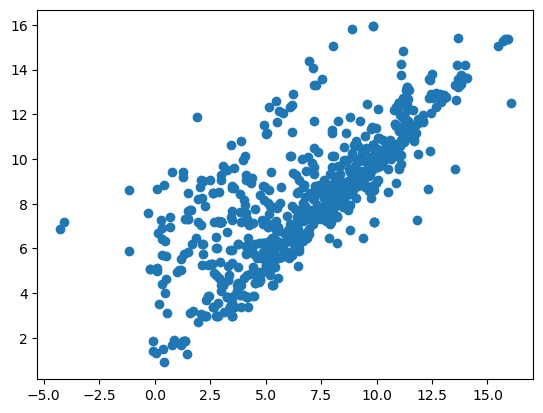

2195.6  52.068999999999996
58310.0  2088.37288
59.0  41218.95515328975
68200.0  33576.05045000001
20892961.31  7527.666500000001
125.89  1379.0383199999999
518.0  1418.4060421212123
460.0  10881.831400000001
5780.0  62705.873265
1500.0  6307.845137198088


In [20]:
predictions = model_time_split.predict(X_test_time_split)
plt.scatter(np.log(y_test_time_split), np.log(predictions))
plt.show()
for i in range(10):
    print(f'{y_test[i]}  {predictions[i]}')

**(optional) Excercise 1.2.** *(label transformations)*

As mentioned above, using the logarithmic values can improve the prediction results by eliminating extreme values. Another option is to transform continuous measurements into binary classes, where active compounds are those with IC$_{50}$/Ki values below a certain treshold, and the rest is assumed inactive. This approach can also help dealing with inaccurate noisy measurements.

Try to convert labels into pIC$_{50}$/pKi values or change the regression task to a binary classification problem.

In [21]:
# I will predict pIC50
featurizer_pIC50 = Featurizer(use_logarithm=True)
X_train_pIC50, y_train_pIC50 = featurizer_pIC50(df_train)
X_test_pIC50, y_test_pIC50 = featurizer_pIC50(df_test)

model_pIC50 = MLPRegressor().fit(X_train_pIC50, y_train_pIC50)

predictions = model_pIC50.predict(X_test_pIC50)
rmse_score = rmse(y_test_pIC50, predictions)
mae_score = mae(y_test_pIC50, predictions)
r2_score = r_squared(y_test_pIC50, predictions)
print(f'RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')

RMSE, MAE, R2 = 0.9037738829951829, 0.6235359384425523, 0.560375906553228


The results for pIC50 are better significantly better than for IC50. Even multi layer perceptron, which appeared to work worse before, gives satisfactory results here.

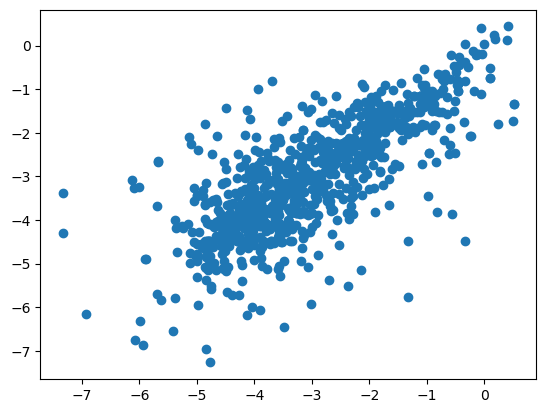

-3.341553222109577  -4.116957355579425
-4.765743041421044  -4.478875829886105
-1.7708520116421442  -1.6486032230203844
-4.833784374656479  -6.950093942119339
-7.3200000000303405  -4.299365234441394
-2.099991233544684  -2.8405117497910983
-2.714329759745233  -3.1683534466111856
-2.6627578316815743  -2.811357373692808
-3.761927838420529  -3.1805207959127193
-3.1760912590556813  -2.7260286091485426


In [22]:
plt.scatter(y_test_pIC50, predictions)
plt.show()
for i in range(10):
    print(f'{y_test_pIC50[i]}  {predictions[i]}')

**(optional) Excercise 1.3.** *(exploratory data analysis, data filtering)*

Can you find any discrepancies in the data? For example, do you find any outliers or duplicated SMILES strings? Can you solve these problems?

In [ ]:
# Hint: A dot in the SMILES string indicates multiple compounds (this is a separator)
df[df.Smiles.str.contains('\.')]

# TODO: Perform Exploratory Data Analysis

# ZINC

[ZINC](https://zinc.docking.org/) is a database of commercially available compounds. This data can be used for **virtual screening**, i.e. finding active molecules using only *in silico* (computer) methods. These compounds can be then purchased and tested *in vitro* (in cells or biomolecules) or *in vivo* (in living organisms).

**Exercise 2.** Perform virtual screening. Use the model trained in Exercise 1 to find the most active compounds in a ZINC subset. Which compounds should be selected to be purchased or synthesized?

Save the output as a CSV file containing 100 compounds (SMILES strings) and their predicted activity values.

In [37]:
# (1) load data
zinc_df = pd.read_csv('zinc.smi', sep=' ')
zinc_df.head()
# (2) convert representation
fingerprints = []
for _, row in zinc_df.iterrows():
    smiles = row['smiles']
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprints.append(fp)
# (3) predict activity
predictions = model_pIC50.predict(fingerprints)

In [38]:
# (4) show drug candidates
indices = np.argpartition(predictions, -100)[-100:]
best_compounds = list()
for i in indices:
    best_compounds.append([zinc_df._get_value(i, 'smiles'), predictions[i]])
output = pd.DataFrame(best_compounds, columns=['smiles', 'pred_pIC50'])
output.to_csv('predictions.csv', index=False, sep=' ')

**(optional) Exercise 2.1.** *(Compound novelty and diversity)*

How similar are the selected compounds to the training data? Can you measure the diversity of these compounds? How should these values impact your selection?

I used function from [here](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity:~:text=%3DTrue\)-,%3E%3E%3E%20DataStructs.DiceSimilarity(fp1%2Cfp2),-0.36...%0A%3E%3E%3E)

As we can see, the compounds are quite different; Unfortunaly, I don't know to what extent was it expected and to what extent is it due to the model imperfections.

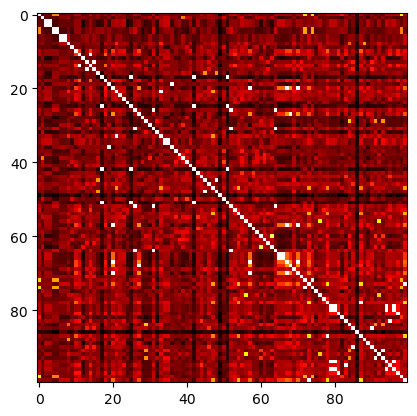

In [39]:
# similar to https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity:~:text=%3DTrue)-,%3E%3E%3E%20DataStructs.DiceSimilarity(fp1%2Cfp2),-0.36...%0A%3E%3E%3E
a = np.ndarray((100,100), dtype='float')
for i, x in enumerate(indices):
    for j, y in enumerate(indices):
        a[i][j] = DataStructs.DiceSimilarity(fingerprints[x], fingerprints[y])
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

You can use **t-SNE** to find structural similarities in your dataset. t-SNE is a tool for high-dimensional data visualization (**dimensionality reduction**). It transforms n-dimensional data into 2-dimensional map in which distances should be proportional to the distances in the original space.

I couldn't get t-SNE to work, so here is PCA instead

In [40]:
from sklearn.decomposition import PCA

def get_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4)
    return np.array(fingerprint)

df_zinc = pd.read_csv('zinc.smi', sep=' ', index_col=1).sample(n=1000)
df_zinc['fingerprint'] = [get_morgan(smiles) for smiles in df_zinc.smiles]
df_best = pd.read_csv('predictions.csv', sep=' ', index_col=1)
df_best['fingerprint'] = [get_morgan(smiles) for smiles in df_best.smiles]

In [41]:
pca = PCA(n_components=2)
pca.fit(np.stack(df_zinc.fingerprint))
random_sample = pca.transform(np.stack(df_zinc.fingerprint))
chosen_sample = pca.transform(np.stack(df_best.fingerprint))

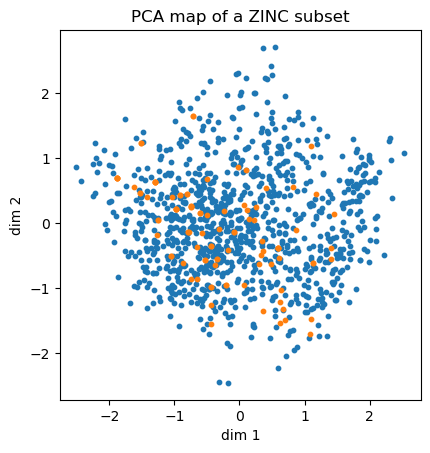

In [44]:
plt.scatter(random_sample[:, 0], random_sample[:, 1], s=10)
plt.scatter(chosen_sample[:, 0], chosen_sample[:, 1], s=10)
plt.gca().set_aspect('equal')
plt.title('PCA map of a ZINC subset')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

**(optional) Exercise 2.2.** *(Additional ADMET filters)*

When selecting compounds, we need to consider also other properties, e.g. toxicity. Some structural patterns are well known to cause issues in terms of toxicity or synthesizability. We can quickly filter out compounds containing these patterns using their SMARTS strings ("regular expressions" for SMILES).

Use [SureChEMBL](https://www.surechembl.org/search/) to remove problematic compounds.

In [ ]:
# TODO: Use SMARTS to filter out compounds

# PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is a database of chemical information about small molecules. It contains various ADMET properties and 3D crystal structures of these molecules. You can easily find any compound using the SMILES representation or by drawing the structure in the tool on the website.

**(optional) Exercise 3.** What information can you find about your selected top compounds?